# Evaluating Performance - House Price Model
In this exercise, we'll work with the housing price data from the previous checkpoint. 

## Load the dataset from Thinkful's database

In [18]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [20]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
house_price = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

#Close the connection after query is complete
engine.dispose()

## Clean and transform the data

In [21]:
#Drop features
drop_list = list((house_price.isnull().sum()/house_price.isnull().count()).sort_values(ascending=False).head(19).index)
drop_list.append('id')

house_price = house_price.drop(drop_list, axis=1)

#List of features that are string categoricals
str_cat_cols = list(house_price.describe(include=['O']).columns)

#Uniques within each variable
uniques = pd.DataFrame()
uni_col = []
num_uni = []
avgdiff_uni = []

for col in list(house_price.columns):
    uni_col.append(list(np.unique(house_price[col])))
    num_uni.append(len(np.unique(house_price[col])))
    try:
        avgdiff_uni.append(np.mean(np.diff(np.unique(house_price[col]))))
    except: 
        avgdiff_uni.append('N/A')
    
uniques['Category'] = list(house_price.columns)
uniques['Unique Values'] = uni_col
uniques['Num Uniques'] = num_uni
uniques['Avg Diff Among Uniques'] = avgdiff_uni


#List of features that are numerical categoricals
#If a numerical variable is categorical, its unique values will tend to be close to each other and there shouldn't
#be too many unique values 
num_cat_cols = []
for col in list(house_price.columns):
    if col not in str_cat_cols:   
        if ((list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 2) or ((list(uniques[uniques['Category']==col]['Num Uniques'])[0] < 20) and (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 20))):
            num_cat_cols.append(col)
            
#List of features that are numerical continuous
cont_cols = []
for col in list(house_price.columns):
    if ((col not in str_cat_cols) and (col not in num_cat_cols)):
        cont_cols.append(col)
        
#Create new dataframe containing features of interest
sale_df = house_price[['saleprice', 'grlivarea', 'garagearea', 'totalbsmtsf', 'overallqual', 'paveddrive', 'centralair', 'yearremodadd']]

#Convert string categoricals ('paveddrive' and 'centralair') to dummy numerical
unique_paved = ['N', 'P', 'Y']
dummy_paveddrive = []
for row in sale_df['paveddrive']:
    for i in range(len(unique_paved)):
        if row == unique_paved[i]:
            dummy_paveddrive.append(i)
        
sale_df['paveddrive'] = dummy_paveddrive

unique_ac = ['N', 'Y']
dummy_ac = []
for row in sale_df['centralair']:
    for i in range(len(unique_ac)):
        if row == unique_ac[i]:
            dummy_ac.append(i)
        
sale_df['centralair'] = dummy_ac

## Build a linear regression model where the target variable is saleprice. 

In [22]:
target_var = 'saleprice'

sale_df = sale_df.drop(['paveddrive', 'centralair'], axis=1)
#In a previous module, we found that paveddrive and centralair didn't provide statistically significant information
feature_set = list(sale_df.columns.drop(['saleprice']))

# X is the feature set 
X = sale_df[feature_set]
# Y is the target variable
Y = sale_df[target_var]

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     948.6
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:46:01   Log-Likelihood:                -17486.
No. Observations:                1460   AIC:                         3.498e+04
Df Residuals:                    1454   BIC:                         3.502e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.076e+05   1.14e+05     -7.942   

For the current model, the important values are as follows:
 - R-squared: 0.765
 - Adjusted R-squared: 0.765
 - F-statistic: 948.6
 - AIC: 3.498E+04
 - BIC: 3.502E+04
These values indicate a satisfactory model (relatively high R-squared, relatively low AIC and BIC), but there is still room for improvement. 

## In order to improve the goodness of fit of our model, let's try different model specifications by adding or removing some variables.

In [23]:
#Current features being analyzed:
sale_df.columns

Index(['saleprice', 'grlivarea', 'garagearea', 'totalbsmtsf', 'overallqual',
       'yearremodadd'],
      dtype='object')

### Interaction of area features

In [24]:
#Add in the interaction of the area features
sale_df['all_area'] = sale_df['grlivarea'] * sale_df['garagearea'] * sale_df['totalbsmtsf']

feature_set = list(sale_df.columns.drop(['saleprice']))

# X is the feature set 
X = sale_df[feature_set]
# Y is the target variable
Y = sale_df[target_var]

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     853.4
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:46:02   Log-Likelihood:                -17442.
No. Observations:                1460   AIC:                         3.490e+04
Df Residuals:                    1453   BIC:                         3.494e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.039e+05   1.11e+05     -8.146   

Although including an interaction feature of all of the area/square footage features did improve all of the fit values (R-squared, AIC, BIC, etc), the coefficient for the interaction feature is on the order of 10^-6, which tells me that the interaction feature has very little effect on the overall model. Let's see if we can find something better.

### Remove variables with high correlation to each other

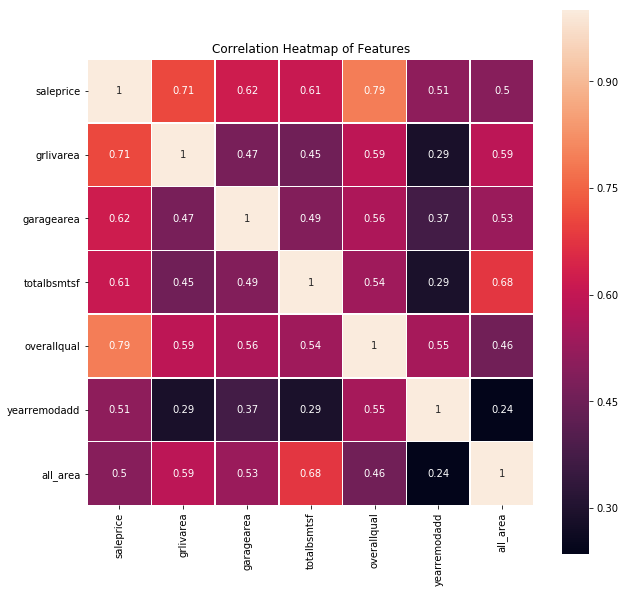

,saleprice,grlivarea,garagearea,totalbsmtsf,overallqual,yearremodadd,all_area
saleprice,1.000000,0.708624,0.623431,0.613581,0.790982,0.507101,0.495875
grlivarea,0.708624,1.000000,0.468997,0.454868,0.593007,0.287389,0.588340
garagearea,0.623431,0.468997,1.000000,0.486665,0.562022,0.371600,0.528712
totalbsmtsf,0.613581,0.454868,0.486665,1.000000,0.537808,0.291066,0.680092
overallqual,0.790982,0.593007,0.562022,0.537808,1.000000,0.550684,0.457143
yearremodadd,0.507101,0.287389,0.371600,0.291066,0.550684,1.000000,0.235163
all_area,0.495875,0.588340,0.528712,0.680092,0.457143,0.235163,1.000000


In [25]:
#Compare the correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(sale_df.corr()), square=True, linewidths=.5, annot=True)
plt.title('Correlation Heatmap of Features')
plt.show()

sale_df.corr()

We can see that the all of the area features are highly correlated with the new all_area feature, which makes sense. However, because all three of the area variables have a higher correlation to saleprice than the single interaction area variable, we should drop all_area from our analysis. Additionally, yearremodadd isn't very strongly correlated with saleprice, so I will drop that variable from the new model.

In [26]:
#Remove variables
sale_df = sale_df.drop(['all_area', 'yearremodadd'], axis=1)

feature_set = list(sale_df.columns.drop(['saleprice']))

# X is the feature set 
X = sale_df[feature_set]
# Y is the target variable
Y = sale_df[target_var]

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     1135.
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:46:12   Log-Likelihood:                -17510.
No. Observations:                1460   AIC:                         3.503e+04
Df Residuals:                    1455   BIC:                         3.506e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.984e+04   4670.871    -21.375      

This version of the model doesn't perform as well as the original nor the version containing the area interaction feature. Therefore, I will conclude that, based solely on the summary values, our best model for predicting saleprice of a house is the one containing both the originally chosen features and the created interaction feature. That model provides an explanation for almost 78% of the variance in the dataset, leaving only 22% unexplained.